# Demo of comparison of SCF with Filter  (NeurIPS'21)

## 1. Introduction

Filter, also known as *Renyi Filter*, is an individual privacy accounting method that monitors the **accumulation of squared gradient norms for each record** (i.e., $\sum_{j=1}^{t-1}\|\bar{g}_j(X_i)\|_2$) during the training process. The record will be filtered out if this accumulation exceeds a pre-specified threshold (i.e., $B_{norm}$).
<img src="./figures/filter_pseudocode.png" width="700"/>

Ref: Algorithm 3 in the NeurIPS'21 paper [Individual Privacy Accounting via a Rényi Filter](https://proceedings.neurips.cc/paper/2021/hash/ec7f346604f518906d35ef0492709f78-Abstract.html))


## 2. Differences in terms of the meaning of *"budget"*

While both Filter and our SCF share a common objective of achieving personalized privacy protection, they significantly differ in the meaning of **"budgets"**: 
- *Filter* considers a budget for the accumulative *squared gradient norms* $B_{norm}$ of each record; 
- *SCF* focuses on the DP privacy budget $\varepsilon$ that controls the accumulative *privacy cost* of each record. 

We highlight that there is an absence of explicit guidelines regarding adjusting the hyperparameters of *squared norm budget* to match a desired privacy budget $\varepsilon$ in the original Filter paper. So achieving a smooth transition between the two quantities is challenging. And thus it poses great difficulties to ensure a fair comparison between Filter and SCF, especially in personalized privacy scenarios with diverse privacy preferences among individuals (such as BoundedMixGauss or BoundedPareto). 

Therefore, in this demo, we only consider a simplified personalized privacy scenario *ThreeLevels*, where the percentage of records with $\varepsilon_1$, $\varepsilon_2$, and $\varepsilon_3$ is 70\%, 20\%, and 10\%, respectively. 

In [1]:
import numpy as np
import os
import sys
sys.path.append("..")
import torch
from torch.utils.data import Subset
from datasets.fed_heart_disease import FedClass, RawClass

project_abspath = os.path.abspath(os.path.join(os.getcwd(),".."))
data_path = os.path.join(project_abspath, "datasets/heart_disease")

rawdata = RawClass(data_path=data_path)
train_data = FedClass(rawdata=rawdata, train=True, pooled=True)
test_data = FedClass(rawdata=rawdata, train=False, pooled=True)
total_points = len(train_data)
num_level1 = int(total_points * 0.7)
num_level2 = int(total_points * 0.2)
num_level3 = total_points - num_level1 - num_level2
num_levels = [num_level1, num_level2, num_level3]

len(train_data), len(test_data)

(486, 254)

## 3. Experimental setups: private (batch) gradient descent

Note that Filter performs private model training via **(batch) gradient descenet** rather than the stochastic variants. That is, it clips the norm of **all gradients** at every step and adds Gaussian noise to the clipped gradients. After the round at which private GD would halt, we look at the **leftover** privacy budget for all points, and utilize them until their budget runs out.

This is because (we quote the explainations from the original paper):
> "We remark that, in practice, it is more common to use private SGD, rather than batch GD. While in principle it is possible to compute individual privacy parameters for SGD, random subsampling of points requires computing gradients for all points at every step to observe gains from individual accounting. As a result, SGD is no less computationally expensive than batch GD in the context of individual accounting."

Adhering to the configuration specified in the original paper, in this demo, we consider incorporating Filter into the private **(batch) gradient descent** algorithm. On the other hand, we combine SCF with the vanilla **DP-SGD** algorithm (we stick to using stochastic GD since the key idea of SCF is the application of non-uniform sampling). Both experiments share the same objective of training a private model on the pooled *Fed-Heart-Disease* dataset.

In [2]:
import pandas as pd
import warnings
warnings.simplefilter("ignore")

import torch
from torch.utils.data import DataLoader
from datasets.fed_heart_disease import BaselineModel, BaselineLoss, Optimizer, metric

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyper-parameters for *both* methods
MAX_STEPS = 150
LR_DP = 0.1
TARGET_DELTA = 0.001
MAX_GRAD_NORM = 1.0

train_dataloader = DataLoader(train_data, batch_size=len(train_data))
test_dataloader = DataLoader(test_data, batch_size=len(test_data))
model_init = BaselineModel.to(device)
criterion = BaselineLoss()

## 3. Private GD with Filter

In [3]:
# Hyper-parameters for **Filter** method
NOISE_MULTIPLIER = 10.0
NORM_SQ_BUDGETS = [5., 20., 100.] # We choose 100 to ensure those points will be filtered out at round 100
norm_sq_budgets = np.concatenate([[x]*count for count, x in zip(num_levels, NORM_SQ_BUDGETS)], axis=None)

In [4]:
import copy
from myopacus.accountants.analysis.rdp import generate_rdp_orders
from torchdp import PrivacyEngine

_model = copy.deepcopy(model_init)
_optimizer = torch.optim.SGD(_model.parameters(), lr=LR_DP, momentum=0)
_train_loader = copy.deepcopy(train_dataloader)
_test_loader = copy.deepcopy(test_dataloader)

privacy_engine = PrivacyEngine(
    module=_model,
    batch_size=total_points,
    sample_size=total_points,
    alphas=generate_rdp_orders(),
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
    norm_sq_budget=norm_sq_budgets,
    should_clip=True,
)
privacy_engine.attach(_optimizer)

Warning! Tensorboard library was not found.


In [5]:
import json
import time
from tqdm.notebook import tqdm

running_grad_sq_norms = [ torch.Tensor([0] * total_points).to(device) ]
results_all_reps = [
    {
        "train_loss": 0., 
        "train_acc": 0., 
        "test_loss": 0., 
        "test_acc": 0., 
        "seconds": 0., 
        "num_active_points": total_points,
        "norm_sq_budgets": NORM_SQ_BUDGETS, 
        "e": json.dumps({0: 0, num_level1:0, num_level1+num_level2:0}), 
        "d": TARGET_DELTA, 
        "nm": round(NOISE_MULTIPLIER, 2), 
        "norm": MAX_GRAD_NORM
    }
]

pbar = tqdm(total = MAX_STEPS)
for step in range(1, MAX_STEPS+1):
    _model.train()
    _optimizer.zero_grad()
    start = time.time()

    data, target = next(iter(_train_loader))
    data, target = data.to(device), target.to(device)
    output = _model(data)
    loss = criterion(input=output, target=target)

    train_correct = metric(y_true=target.detach().cpu().numpy(), y_pred=output.detach().cpu().numpy())
    train_acc = 1. * train_correct / len(target)
    train_loss = loss.item()
    
    loss.backward()
    grad_norms = _optimizer.step(running_grad_sq_norms[-1])
    grad_norms_sq = grad_norms * grad_norms
    running_grad_sq_norms.append(running_grad_sq_norms[-1] + grad_norms_sq)
    seconds = time.time() - start

    # compute activate points & privacy costs
    temp = running_grad_sq_norms[-1].cpu().numpy()
    num_active_points = np.sum(np.round(temp, 4) < np.array(norm_sq_budgets))
    epsilon1 = privacy_engine.get_epsilon(temp[0], TARGET_DELTA)[0]
    epsilon2 = privacy_engine.get_epsilon(temp[num_level1], TARGET_DELTA)[0]
    epsilon3 = privacy_engine.get_epsilon(temp[num_level1 + num_level2], TARGET_DELTA)[0]
    
    # performance on test data
    with torch.no_grad():
        _model.eval()
        data, target = next(iter(_test_loader))
        data, target = data.to(device), target.to(device)
        output = _model(data)
        test_loss = criterion(input=output, target=target).item()
        test_correct = metric(y_true=target.detach().cpu().numpy(), y_pred=output.detach().cpu().numpy())
        test_acc = 1. * test_correct / len(target)

    results_all_reps.append(
        {
            "train_loss": round(train_loss,4), 
            "train_acc": round(train_acc,4), 
            "test_loss": round(test_loss,4), 
            "test_acc": round(test_acc,4), 
            "seconds": round(seconds,4), 
            "num_active_points": num_active_points.item(),
            "norm_sq_budgets": set(running_grad_sq_norms[-1].cpu().numpy()),
            "e": json.dumps({0:epsilon1, num_level1:epsilon2, num_level1+num_level2:epsilon3}), 
            "d": TARGET_DELTA, 
            "nm": round(NOISE_MULTIPLIER,2), 
            "norm": MAX_GRAD_NORM
        }
    )
    pbar.update(1)
    pbar.set_postfix({
        "epsilon1": f"{round(epsilon1,2)}",
        "epsilon2": f"{round(epsilon2,2)}",
        "epsilon3": f"{round(epsilon3,2)}",
        "test_acc": f"{round(test_acc,4)}",
        "seconds": f"{round(seconds,4)}",
        "num_active_points": f"{num_active_points.item()}",
    })
    
    if num_active_points < 10:
        break
        
results = pd.DataFrame.from_dict(results_all_reps)
results.to_csv("results_filter.csv", index=False)
del privacy_engine, _model, _optimizer, _train_loader, _test_loader, results

  0%|          | 0/150 [00:00<?, ?it/s]

### Experimental results

In [6]:
results_filter = pd.read_csv("results_filter.csv")
runtimes_filter = round(np.array(results_filter["seconds"].tolist()).mean(), 4)
trainacc_filter = round(np.array(results_filter["train_acc"].tolist()[-5:]).mean(), 4)
testacc_filter = round(np.array(results_filter["test_acc"].tolist()[-5:]).mean(), 4)
print("Average runtime: ", np.array(results_filter["seconds"].tolist()).mean())
print(
    f"DP guarantees: δ = {TARGET_DELTA} ε1 = {epsilon1:.4f} ε2 = {epsilon2:.4f} ε3 = {epsilon3:.4f}."
)

Average runtime:  0.008580733944954129
DP guarantees: δ = 0.001 ε1 = 0.8563 ε2 = 1.7635 ε3 = 4.2269.


Number of active points:  [486 486 486 486 486 159 154 153 148 147 146 146 146 146 146 146 146 146
 146 146  60  58  56  54  53  52  52  51  50  50  50  50  50  50  50  50
  50  50  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49
  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49
  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49  49
  49  49  49  49  49  49  49  49  49  49  27  13  12  12  11  11  11  10
   9] 108


(0.0, 1.0)

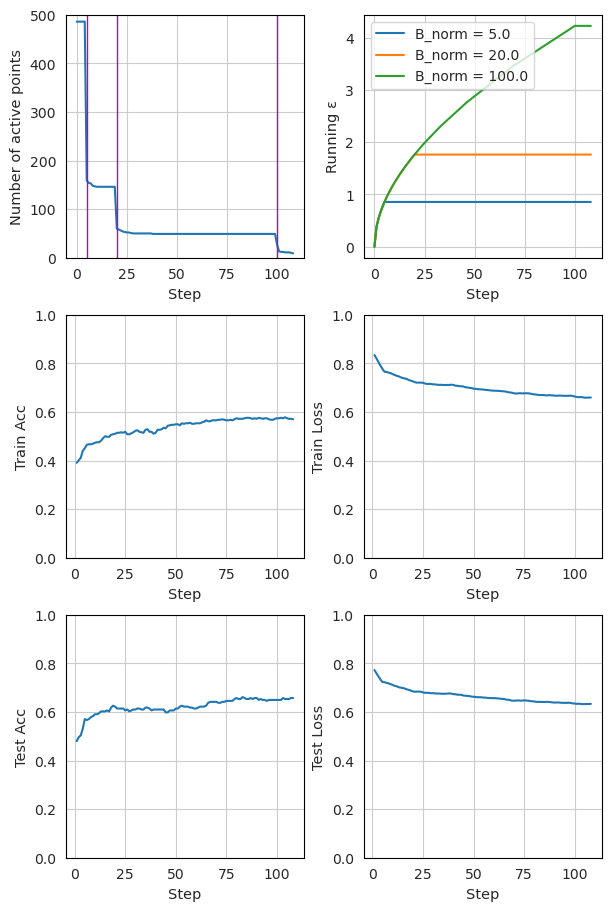

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid', {'axes.linewidth': 1, 'axes.edgecolor':'black'}) #风格、轮廓线
legend_font = {'style': 'normal', 'size': 8, 'weight': "normal"}
label_font = {'family':'sans-serif', 'size': 10.5, 'weight': "normal"}
title_font = {'family':'sans-serif', 'size': 10.5, 'weight': "bold"}

fig, axs = plt.subplots(3, 2, figsize=(6, 9), constrained_layout=True, dpi=100)

# plot #0: number of active points
ax=axs[0][0]
active_points = np.array(results_filter["num_active_points"].tolist())
xrange = len(active_points[1:])
print("Number of active points: ", active_points, len(active_points[1:]))
sns.lineplot(x=range(xrange+1), y=active_points, ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Number of active points", **label_font)
ax.set_ylim(0, 500)
ax.axvline(np.floor(norm_sq_budgets[0]/(MAX_GRAD_NORM**2)), 0, 1, c='m', linewidth = 1)
ax.axvline(np.floor(norm_sq_budgets[num_level1]/(MAX_GRAD_NORM**2)), 0, 1, c='m', linewidth = 1)
ax.axvline(np.floor(norm_sq_budgets[num_level1 + num_level2]/(MAX_GRAD_NORM**2)), 0, 1, c='m', linewidth = 1)

# plot #1: epsilons
ax=axs[0][1]
def preprocess_running_epsilon(my_results):
    keys = list(json.loads(my_results[0]).keys())
    running_epsilons = dict(zip(keys, [[] for _ in range(len(keys))]))
    for dict_str in my_results:
        for key, value in list(json.loads(dict_str).items()):
            running_epsilons[key].append(round(value, 4))
    return running_epsilons
running_epsilons = preprocess_running_epsilon(results_filter["e"].tolist())
for key, values in running_epsilons.items():
    sns.lineplot(x=range(xrange+1), y=values, label=f"B_norm = {norm_sq_budgets[int(key)]}", ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Running ε", **label_font)

# plot #2: train_acc
ax=axs[1][0]
train_acc = np.array(results_filter["train_acc"].tolist())
sns.lineplot(x=range(1,xrange+1), y=train_acc[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Train Acc", **label_font)
ax.set_ylim(0, 1.0)

# plot #3: train_loss
ax=axs[1][1]
train_loss = np.array(results_filter["train_loss"].tolist())
sns.lineplot(x=range(1,xrange+1), y=train_loss[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Train Loss", **label_font)
ax.set_ylim(0, 1.0)

# plot #4: test_acc
ax=axs[2][0]
test_acc = np.array(results_filter["test_acc"].tolist())
sns.lineplot(x=range(1,xrange+1), y=test_acc[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Test Acc", **label_font)
ax.set_ylim(0, 1.0)

# plot #5: test_loss
ax=axs[2][1]
test_loss = np.array(results_filter["test_loss"].tolist())
sns.lineplot(x=range(1,xrange+1), y=test_loss[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Test Loss", **label_font)
ax.set_ylim(0, 1.0)

## 4. Private SGD with SCF

In [8]:
from myopacus import PrivacyEngine
# Hyper-parameters for **SCF** method
NUM_STEPS = len(test_acc[1:])
MAX_PHYSICAL_BATCH_SIZE = 256
TARGET_EPSILONS = [epsilon1, epsilon2, epsilon3]
target_epsilons = np.concatenate([[x]*count for count, x in zip(num_levels, TARGET_EPSILONS)], axis=None)

In [9]:
_model = copy.deepcopy(model_init)
_optimizer = torch.optim.SGD(_model.parameters(), lr=LR_DP, momentum=0)
_train_loader = copy.deepcopy(train_dataloader)
_test_loader = copy.deepcopy(test_dataloader)

privacy_engine = PrivacyEngine(accountant="fed_rdp", n_clients=1)
_model, _optimizer, _train_loader = privacy_engine.make_private_with_personalization(
    module=_model,
    optimizer=_optimizer,
    data_loader=_train_loader,
    num_steps=NUM_STEPS,
    target_epsilons=target_epsilons,
    target_delta=TARGET_DELTA,
    noise_multiplier=NOISE_MULTIPLIER,
    max_grad_norm=MAX_GRAD_NORM,
    max_physical_batch_size=MAX_PHYSICAL_BATCH_SIZE
)
np.unique(privacy_engine.accountant.sample_rate)

noise_multiplier :  10.0
The R-Squared value of the best-fit curve : 0.999873069285222
expected_batch_size:  197


array([0.28303427, 0.53548532, 1.        ])

In [10]:
results_all_reps = [
    {
        "train_loss": 0., 
        "train_acc": 0., 
        "test_loss": 0., 
        "test_acc": 0., 
        "seconds": 0., 
        "num_participant_points": 0,
        "e": json.dumps({0: 0., num_level1:0., num_level1+num_level2:0.}),
        "d": TARGET_DELTA, 
        "nm": round(privacy_engine.accountant.noise_multiplier,2), 
        "norm": MAX_GRAD_NORM
    }
]
pbar = tqdm(total = NUM_STEPS)
for i in range(1, NUM_STEPS+1):
    _model.train()
    _optimizer.zero_grad()
    start = time.time()
    
    data, target = next(iter(_train_loader))
    data, target = data.to(device), target.to(device)
    output = _model(data)
    loss = criterion(input=output, target=target)

    train_correct = metric(y_true=target.detach().cpu().numpy(), y_pred=output.detach().cpu().numpy())
    train_acc = 1. * train_correct / len(target)
    train_loss = loss.item()
    
    loss.backward()
    _optimizer.step()
    seconds = time.time() - start
    
    num_participant_points = len(target)
    epsilon1 = privacy_engine.get_epsilon_by_id(id=0, target_delta=TARGET_DELTA)
    epsilon2 = privacy_engine.get_epsilon_by_id(id=num_level1, target_delta=TARGET_DELTA)
    epsilon3 = privacy_engine.get_epsilon_by_id(id=num_level1+num_level2, target_delta=TARGET_DELTA)

    # performance on test data
    with torch.no_grad():
        _model.eval()
        data, target = next(iter(_test_loader))
        
        data, target = data.to(device), target.to(device)
        output = _model(data)
        test_loss = criterion(input=output, target=target).item()
        test_correct = metric(y_true=target.detach().cpu().numpy(), y_pred=output.detach().cpu().numpy())
        test_acc = 1. * test_correct / len(target)

    results_all_reps.append(
        {
            "train_loss": round(train_loss,4), 
            "train_acc": round(train_acc,4), 
            "test_loss": round(test_loss,4), 
            "test_acc": round(test_acc,4), 
            "seconds": round(seconds,4),
            "num_participant_points": num_participant_points,
            "e": json.dumps({0:epsilon1, num_level1:epsilon2, num_level1+num_level2:epsilon3}), 
            "d": TARGET_DELTA, 
            "nm": round(privacy_engine.accountant.noise_multiplier,2), 
            "norm": MAX_GRAD_NORM
        }
    )
    pbar.update(1)

results = pd.DataFrame.from_dict(results_all_reps)
results.to_csv("results_scf.csv", index=False)

  0%|          | 0/108 [00:00<?, ?it/s]

### Experimental results

In [11]:
results_scf = pd.read_csv("results_scf.csv")
runtimes_scf = round(np.array(results_scf["seconds"].tolist()).mean(), 4)
trainacc_scf = round(np.array(results_scf["train_acc"].tolist()[-5:]).mean(), 4)
testacc_scf = round(np.array(results_scf["test_acc"].tolist()[-5:]).mean(), 4)
print("Average runtime: ", runtimes_scf)
print(
    f"DP guarantees: δ = {TARGET_DELTA} ε1 = {epsilon1:.4f} ε2 = {epsilon2:.4f} ε3 = {epsilon3:.4f}."
)

Average runtime:  0.0064
DP guarantees: δ = 0.001 ε1 = 0.8427 ε2 = 1.7743 ε3 = 3.7128.


Number of participants points:  [203 201 201 200 189 204 195 193 196 203 203 186 185 205 195 191 201 200
 202 189 199 190 192 204 196 215 211 188 192 211 211 198 200 189 196 203
 208 200 188 195 197 186 206 211 192 193 199 198 192 210 204 183 198 183
 191 203 201 202 201 203 197 193 189 199 209 198 208 186 203 194 216 200
 201 206 192 190 215 203 221 202 194 209 209 200 189 206 203 186 188 195
 196 198 189 186 187 211 182 203 214 201 201 197 204 201 192 199 205 195]


(0.0, 1.0)

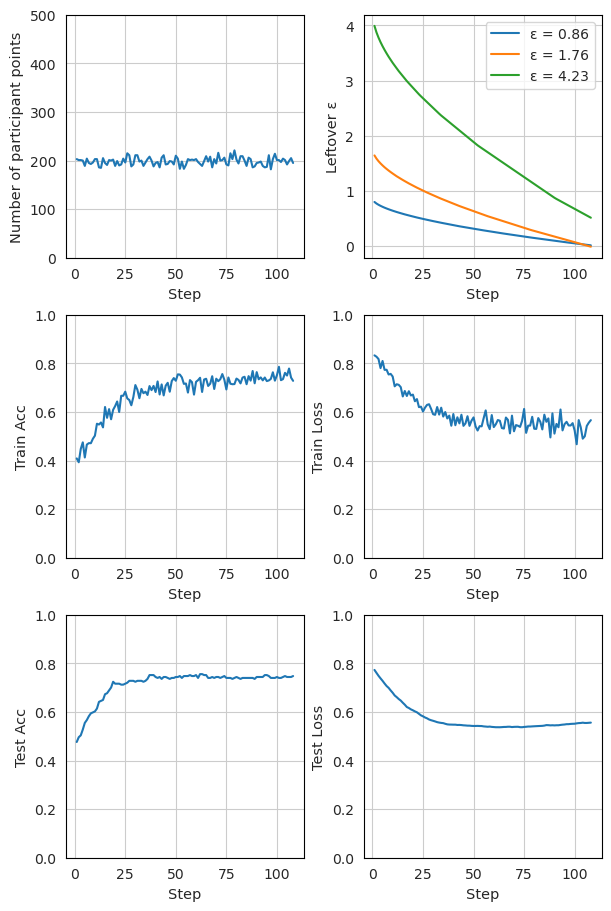

In [12]:
fig, axs = plt.subplots(3, 2, figsize=(6, 9), constrained_layout=True, dpi=100)

# plot #0: number of participant points
ax=axs[0][0]
participant_points = np.array(results_scf["num_participant_points"].tolist())
xrange = len(participant_points[1:])
print("Number of participants points: ", participant_points[1:])
sns.lineplot(x=range(1,xrange+1), y=participant_points[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Number of participant points", **label_font)
ax.set_ylim(0, 500)

# plot #1: epsilons
ax=axs[0][1]
running_epsilons = preprocess_running_epsilon(results_scf["e"].tolist())
for key, values in running_epsilons.items():
    leftover = np.ones(xrange)*1.0*target_epsilons[int(key)] - np.array(values[1:])
    sns.lineplot(x=range(1,xrange+1), y=leftover, label=f"ε = {round(target_epsilons[int(key)], 2)}", ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Leftover ε", **label_font)
# ax.set_ylim(0, 500)

# plot #2: train_acc
ax=axs[1][0]
train_acc = np.array(results_scf["train_acc"].tolist())
sns.lineplot(x=range(1,xrange+1), y=train_acc[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Train Acc", **label_font)
ax.set_ylim(0, 1.0)

# plot #3: train_loss
ax=axs[1][1]
train_loss = np.array(results_scf["train_loss"].tolist())
sns.lineplot(x=range(1,xrange+1), y=train_loss[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Train Loss", **label_font)
ax.set_ylim(0, 1.0)

# plot #4: test_acc
ax=axs[2][0]
test_acc = np.array(results_scf["test_acc"].tolist())
sns.lineplot(x=range(1,xrange+1), y=test_acc[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Test Acc", **label_font)
ax.set_ylim(0, 1.0)

# plot #5: test_loss
ax=axs[2][1]
test_loss = np.array(results_scf["test_loss"].tolist())
sns.lineplot(x=range(1,xrange+1), y=test_loss[1:], ax=ax)
ax.set_xlabel("Step", **label_font)
ax.set_ylabel("Test Loss", **label_font)
ax.set_ylim(0, 1.0)


# Conclusion

The results shown in the following table demonstrate that *SCF* outperforms *Filter* in terms of test accuracy and runtime per update step.

In [13]:
%pip install tabulate
from tabulate import tabulate
mydata = [
    [f"Filter", f"{trainacc_filter}", f"{testacc_filter}", f"{runtimes_filter}",],
    [f"SCF", f"{trainacc_scf}", f"{testacc_scf}", f"{runtimes_scf}",],
]
head = ["Method", "Train Acc", "Test Acc", "Runtime (s)"]
print(tabulate(mydata, headers=head, tablefmt="grid"))

Note: you may need to restart the kernel to use updated packages.
+----------+-------------+------------+---------------+
| Method   |   Train Acc |   Test Acc |   Runtime (s) |
+==========+=============+============+===============+
| Filter   |      0.5733 |     0.6551 |        0.0086 |
+----------+-------------+------------+---------------+
| SCF      |      0.752  |     0.7457 |        0.0064 |
+----------+-------------+------------+---------------+
